In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# #Dataset Loader
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# import os
# import zipfile

# get filename from uploaded dict
# rawfile = next(iter(uploaded))
# extract_path ='/content/'

# with zipfile.ZipFile(rawfile, 'r') as zipRef:
#   zipRef.extractall(extract_path)
# print('Files extracted successfully!!')

In [ ]:
import os
import zipfile
extract_path ='/content/'

with zipfile.ZipFile('/content/llm-classification-finetuning.zip', 'r') as zipRef:
  zipRef.extractall(extract_path)
print('Files extracted successfully!!')

Files extracted successfully!!


In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

train_df.head(2)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0


In [ ]:
sample = pd.read_csv('/content/sample_submission.csv')
sample.head(5)

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.333333,0.333333,0.333333
1,211333,0.333333,0.333333,0.333333
2,1233961,0.333333,0.333333,0.333333


In [ ]:
print(f'Train:\n {train_df.isnull().sum()} \n\nTest: \n{test_df.isnull().sum()}')

Train:
 id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64 

Test: 
id            0
prompt        0
response_a    0
response_b    0
dtype: int64


In [ ]:
train_df.dtypes

,0
id,int64
model_a,object
model_b,object
prompt,object
response_a,object
response_b,object
winner_model_a,int64
winner_model_b,int64
winner_tie,int64


In [ ]:
train_df['prompt'].head()

,prompt
0,"[""Is it morally right to try to have a certain..."
1,"[""What is the difference between marriage lice..."
2,"[""explain function calling. how would you call..."
3,"[""How can I create a test set for a very rare ..."
4,"[""What is the best way to travel from Tel-Aviv..."


EDA

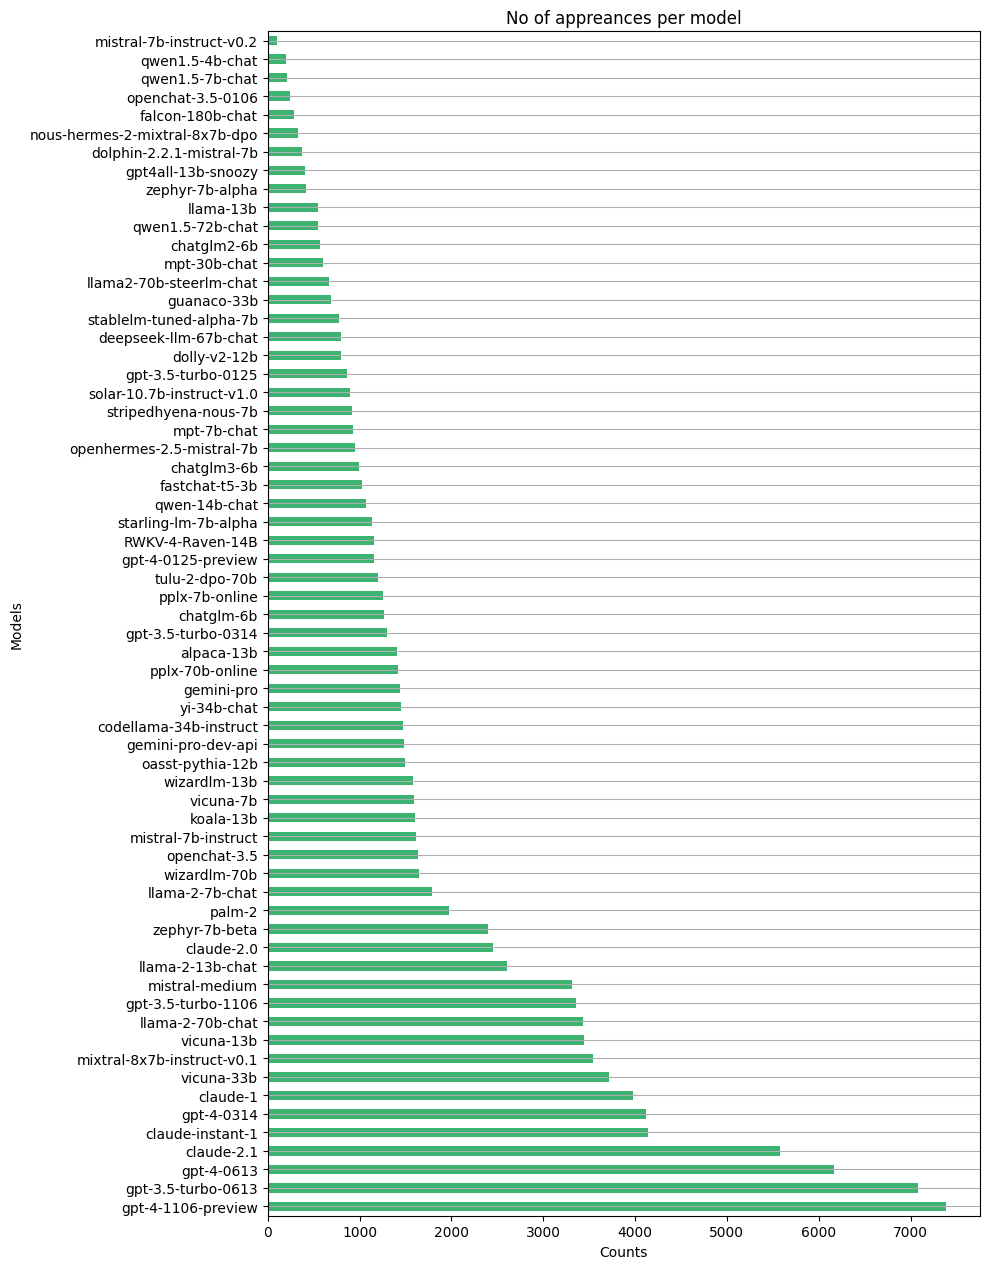

In [ ]:
#count of unique models
model_counts = pd.concat([train_df['model_a'],train_df['model_b']]).value_counts()

#adjust graph to no of models
num_models = len(model_counts)
height_per = 0.2
fig_height =(height_per*num_models)

plt.figure(figsize=(10,fig_height))
model_counts.plot(kind='barh', color ='mediumseagreen')
plt.title('No of appreances per model')
plt.ylabel('Models')
plt.xlabel('Counts')
plt.tight_layout()
plt.grid(True, axis= 'y')
plt.show()

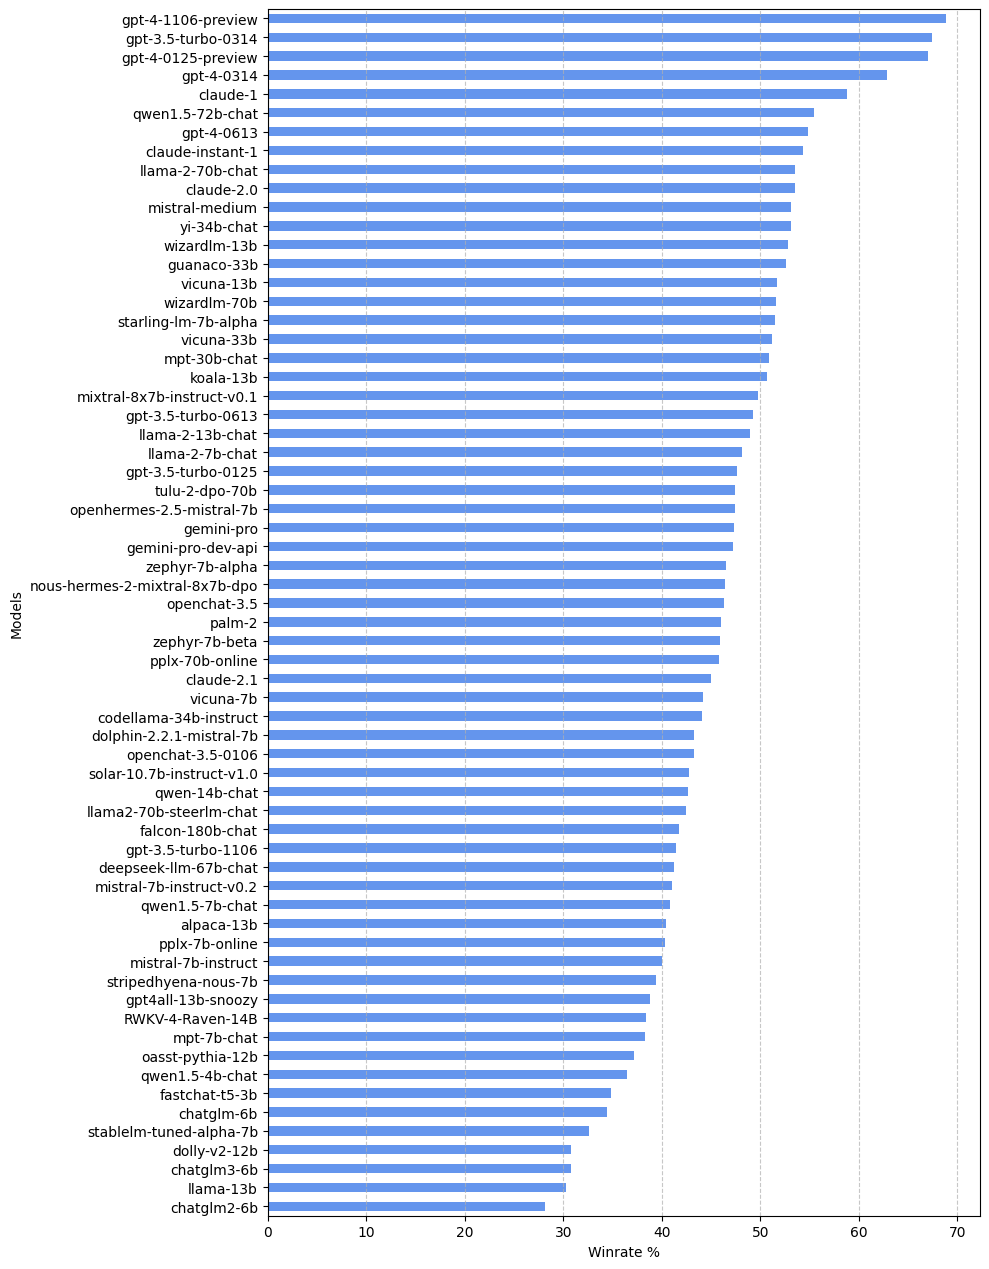

In [ ]:
#winrate of each model (0.5 credit each for ties)

#count wins
win_a = train_df.groupby('model_a')['winner_model_a'].sum()
win_b = train_df.groupby('model_b')['winner_model_b'].sum()

#count ties and credit 0.5 per tie
ties_a = train_df.groupby('model_a')['winner_tie'].sum() * 0.5
ties_b = train_df.groupby('model_b')['winner_tie'].sum() * 0.5

total_wins = win_a.add(win_b, fill_value=0).add(ties_a, fill_value=0).add(ties_b, fill_value=0)
win_rate = round((total_wins/model_counts)*100,2).sort_values(ascending = True)

plt.figure(figsize=(10,fig_height))
win_rate.plot(kind='barh', color='cornflowerblue')
plt.ylabel('Models')
plt.xlabel('Winrate %')
plt.grid(axis='x', linestyle = '--', alpha= 0.7)
plt.tight_layout()
plt.show()

In [ ]:
#target ..winner class
train_df['label'] = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].values.argmax(axis=1)

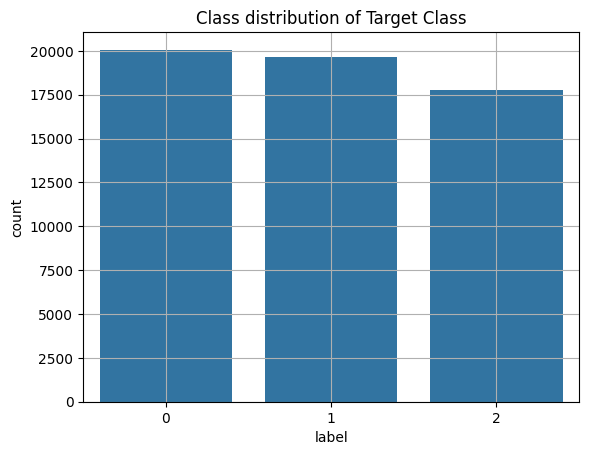

In [ ]:
import seaborn as sns
sns.countplot(x='label', data=train_df)
plt.title('Class distribution of Target Class')
plt.grid('False')
plt.show()

Data Cleaning

In [ ]:
import html
import re
import ast

#function to parse json text and cleanup text
def parse_and_clean(text):

    if isinstance(text, str) and text.strip().startswith('["'):
      try:
        text = " ".join(ast.literal_eval(text))
      except:
        pass # fall back to original text if eval fails

    text = html.unescape(text) # Decode any HTML entities (e.g., &amp;)
    text = text.replace('\\n', '\n').replace('\\/', '/') # Normalize newlines

    try:
      text = bytes(text, 'utf-8').decode('raw_unicode_escape') # Remove stray backslashes or unicode escapes
    except:
      pass
    return text

In [ ]:
for col in ['prompt', 'response_a', 'response_b']:
  train_df[col+'_clean'] = train_df[col].apply(parse_and_clean)
  test_df[col+'_clean'] = test_df[col].apply(parse_and_clean)

train_df.head(2)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,label,prompt_clean,response_a_clean,response_b_clean
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi..."
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...


In [ ]:
(train_df['response_a_clean'][0])

'The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizations and society as a whole.\n\n3. **Equality of Opportunity:** Setting targets for female representation in management can help ensure that women have equal opportunities to advance in their careers.\n\n4. **Role Modeling:*

In [ ]:
#create a combined text for prmpt and responsed from both models
train_df['input'] = (
    'Prompt:\n'+train_df['prompt']+ '\n\n' +
    'Response A:\n'+train_df['response_a']+ '\n\n' +
    'Response B:\n'+train_df['response_b']
)

In [ ]:
train_df['input'].isna().sum()

np.int64(0)

In [ ]:
print(train_df['input'][0])

Prompt:
["Is it morally right to try to have a certain percentage of females on managerial positions?","OK, does pineapple belong on a pizza? Relax and give me fun answer."]

Response A:
["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizations and society as a whole.\n\n3. *

In [ ]:
train_df['label'][0:10]

,label
0,0
1,1
2,2
3,0
4,1
5,1
6,0
7,1
8,1
9,1


### Using Pytorch

#### Data Preprocessing and Splits

In [ ]:
#build vocabulary and tokenizer

from collections import Counter
import torch

#tokenize
def tokenize(text):
  return text.lower().split()

#build vocabulary from training data
alltokens =[]
for text in train_df['input']:
  alltokens.extend(tokenize(text))

#Most common words, reserve 0 for padding and 1 for unknown characters
vocab_size = 20000
special_tokens = {'<PAD>':0, '<UNK>':1}
most_common = Counter(alltokens).most_common(vocab_size-len(special_tokens))  #sample [('the', 100),('be',210)]

#map words and indexes saving 0 and 1 for special tokens
vocab = {word: idx + len(special_tokens) for idx, (word,_) in enumerate(most_common)}
vocab.update(special_tokens)

#encoding sentence
def encode(text, max_len=256):
  tokens = tokenize(text)
  ids = [vocab.get(t, vocab['<UNK>']) for t in tokens][:max_len]
  ids += [vocab['<PAD>']] * (max_len -len(ids))
  return ids

In [ ]:
#train and validation splits
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify= train_df['label'])

In [ ]:
print(train_data.shape)
print(val_data.shape)

(45981, 14)
(11496, 14)


#### Data Loader

In [ ]:
# The Dataset will tokenized inputs and labels, and serve batches of data.
# The DataLoader will handle batching, shuffling (for training), and parallel loading.

import torch
from torch.utils.data import Dataset, DataLoader

#Dataset builder, returns tuple of input and label transformed into tensors
class TextDataset(Dataset):
  def __init__(self, text, labels=None, max_len=256):
    self.text = text
    self.labels = labels
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, idx):
    encoded_text = encode(self.text[idx], self.max_len)
    input_ids = torch.tensor(encoded_text, dtype = torch.long)

    #handle for transforming test data that have no labels
    if self.labels is not None:
      label = torch.tensor(self.labels[idx], dtype=torch.long)
      return input_ids, label
    else:
      return input_ids

In [ ]:
#Build Dataset
train_dataset = TextDataset(train_data['input'].tolist(), train_data['label'].tolist())
val_dataset = TextDataset(val_data['input'].tolist(), val_data['label'].tolist())

In [ ]:
#Data Loader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle= False)

#### Simple NN model in Pytorch

In [ ]:
import torch.nn as nn

class LLM_Rater(nn.Module):
  #vocab_size = unique tokens model learns to create embeddings
  def __init__(self, vocab_size, embed_dim= 128, hidden_dim=64, num_classes=3):
    super(LLM_Rater, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx =0)
    self.fc1 = nn.Linear(embed_dim, hidden_dim)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim, num_classes)

  def forward(self, input_ids):
    embedded = self.embedding(input_ids)
    pooled = embedded.mean(dim=1)
    x = self.relu(self.fc1(pooled))
    output = self.fc2(x)
    return output


#### Base Model Initialization and Training Loop

In [ ]:
vocab_size = len(vocab)
#build model
model = LLM_Rater(vocab_size=vocab_size, embed_dim=128, hidden_dim= 64, num_classes=3)
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

LLM_Rater(
  (embedding): Embedding(20000, 128, padding_idx=0)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)
Total parameters: 2568451
Trainable parameters: 2568451


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

In [ ]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 15

for epoch in range(num_epochs):
  model.train()

  total_train_loss = 0
  train_correct = 0
  train_total = 0

  for input_ids, labels in train_loader:
    input_ids = input_ids.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(input_ids)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #by defualt cross entropy loss is averaged per batch thats why we multiply by batch size to get total loss per batch
    total_train_loss += loss.item()* input_ids.size(0)
    #make prediction
    train_preds = torch.argmax(outputs, dim=1)
    train_correct += (train_preds == labels).sum().item()
    train_total += labels.size(0)

  avg_train_loss = total_train_loss/train_total
  train_accuracy = train_correct/train_total

  #Validation
  model.eval()
  total_val_loss = 0
  val_correct = 0
  val_total = 0
  with torch.no_grad():
    for input_ids, labels in val_loader:
      input_ids = input_ids.to(device)
      labels = labels.to(device)
      outputs = model(input_ids)
      loss = criterion(outputs, labels)

      total_val_loss += loss.item() * input_ids.size(0)
      val_preds = torch.argmax(outputs, dim =1)
      val_correct += (val_preds == labels).sum().item()
      val_total += labels.size(0)

  avg_val_loss = total_val_loss/val_total
  val_accuracy = val_correct/val_total

  print(f"Epoch {epoch+1}/{num_epochs}")
  print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
  print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

Epoch 1/15
Train Loss: 1.0908 | Train Acc: 0.3736
Val Loss: 1.0864 | Val Acc: 0.3883
Epoch 2/15
Train Loss: 1.0819 | Train Acc: 0.3987
Val Loss: 1.0841 | Val Acc: 0.3909
Epoch 3/15
Train Loss: 1.0702 | Train Acc: 0.4195
Val Loss: 1.0859 | Val Acc: 0.3916
Epoch 4/15
Train Loss: 1.0509 | Train Acc: 0.4447
Val Loss: 1.0943 | Val Acc: 0.3939
Epoch 5/15
Train Loss: 1.0245 | Train Acc: 0.4739
Val Loss: 1.1114 | Val Acc: 0.3920
Epoch 6/15
Train Loss: 0.9940 | Train Acc: 0.5040
Val Loss: 1.1312 | Val Acc: 0.3900
Epoch 7/15
Train Loss: 0.9613 | Train Acc: 0.5308
Val Loss: 1.1601 | Val Acc: 0.3893
Epoch 8/15
Train Loss: 0.9292 | Train Acc: 0.5533
Val Loss: 1.1845 | Val Acc: 0.3876
Epoch 9/15
Train Loss: 0.8987 | Train Acc: 0.5761
Val Loss: 1.2238 | Val Acc: 0.3858
Epoch 10/15
Train Loss: 0.8689 | Train Acc: 0.5962
Val Loss: 1.2873 | Val Acc: 0.3740
Epoch 11/15
Train Loss: 0.8412 | Train Acc: 0.6141
Val Loss: 1.3076 | Val Acc: 0.3827
Epoch 12/15
Train Loss: 0.8159 | Train Acc: 0.6294
Val Loss: 1.

In [ ]:
test_df.head(1)

,id,prompt,response_a,response_b,prompt_clean,response_a_clean,response_b_clean
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran...","I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...


In [ ]:
#create a combined text for prmpt and responsed from both models
test_df['input'] = (
    'Prompt:\n'+test_df['prompt']+ '\n\n' +
    'Response A:\n'+test_df['response_a']+ '\n\n' +
    'Response B:\n'+test_df['response_b']
)

test_data = TextDataset(test_df['input'].tolist(), labels =None)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [ ]:
test_df.shape

(3, 8)

In [ ]:
#test predictions
all_preds = []
label_preds =[]

model.eval()
with torch.no_grad():
  for input_ids in test_loader:
    input_ids = input_ids.to(device)
    output = model(input_ids)
    pred = torch.softmax(output, dim=1)
    pred_np = pred.cpu().numpy().round(3)
    all_preds.append(pred_np)
    label_preds.append(torch.argmax(output, dim=1))

print(f'Probability Score:{all_preds}')
print(f'Actual Predictions:{label_preds}')

Probability Score:[array([[0.152, 0.202, 0.646],
       [0.671, 0.299, 0.029],
       [0.208, 0.723, 0.068]], dtype=float32)]
Actual Predictions:[tensor([2, 0, 1])]
